# Time Series Forecasting Using ARIMA\SARIMA Models

This notebook demonstrates a complete workflow for time series forecasting:

1. **Build an ARIMA model** on returns (stationary data)
2. **Forecast** future prices
3. **Visualize** and interpret results

Import Libraries

In [10]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')



Loading Dataset

In [2]:
# Define file path
file_path = "/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"])

## Prepare Data for Modeling

##### Filtering out the  Raw Tesla data

In [3]:
# Filter Tesla scaled data only
raw_tesla_df = df[df["Ticker"] == "TSLA"].copy()

# Sort chronologically
tesla_df = raw_tesla_df.sort_values("Date").reset_index(drop=True)

print(f"Tesla dataset loaded with {tesla_df.shape[0]} rows")
print(f"Date range from {tesla_df['Date'].min()} to {tesla_df['Date'].max()}")


Tesla dataset loaded with 2775 rows
Date range from 2015-01-02 00:00:00 to 2026-01-14 00:00:00


##### Train & Test Split

In [4]:
series = tesla_df.set_index('Date')['Close']
series_returns = series.pct_change().dropna()

# Split chronologically
split_date = pd.Timestamp('2025-01-01')
train = series[series.index < split_date]
test = series[series.index >= split_date]

train_returns = series_returns[series_returns.index < split_date]
test_returns = series_returns[series_returns.index >= split_date]


print(f"Training samples: {len(train)} prices, {len(train_returns)} returns")
print(f"Testing samples: {len(test)} prices, {len(test_returns)} returns")
print(f"\nTraining period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")

Training samples: 2516 prices, 2515 returns
Testing samples: 259 prices, 259 returns

Training period: 2015-01-02 00:00:00 to 2024-12-31 00:00:00
Testing period: 2025-01-02 00:00:00 to 2026-01-14 00:00:00


## Build ARIMA Model on Returns

ARIMA(p, d, q) parameters:
- p = autoregressive order
- d = differencing order (0 since returns are already stationary)
- q = moving average order

In [5]:
# Fit ARIMA model on training returns
model = ARIMA(train_returns, order=(1, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2515
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4792.757
Date:                Mon, 26 Jan 2026   AIC                          -9577.514
Time:                        15:50:33   BIC                          -9554.194
Sample:                             0   HQIC                         -9569.050
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.441      0.015       0.000       0.004
ar.L1          0.8639      0.143      6.027      0.000       0.583       1.145
ma.L1         -0.8494      0.150     -5.678      0.0

## Forecast Returns

In [6]:
# Forecast returns for the test period
n_forecast = len(test_returns)
forecast_returns = model_fit.forecast(steps=n_forecast)

print(f"Forecasted {n_forecast} return values")
print(f"\nForecast statistics:")
print(f"  Mean forecasted return: {forecast_returns.mean():.6f}")
print(f"  Actual mean return: {test_returns.mean():.6f}")

Forecasted 259 return values

Forecast statistics:
  Mean forecasted return: 0.001928
  Actual mean return: 0.001096


- The model forecasted 259 daily return values for the test period, with a mean forecasted return of approximately 0.1928%. This is slightly higher than the actual mean return of 0.1096% observed in the same period. The close similarity between these values indicates that the model captures the overall trend and direction of TSLA returns reasonably well. However, the modest overestimation suggests that while the model is effective at predicting the general return behavior, it may slightly exaggerate the expected gains, potentially due to market volatility or limitations inherent in the ARIMA model.

## Convert Returns Forecast to Prices

In [7]:
# Start from the last training price
last_train = train.iloc[-1]

# Convert returns to prices using cumulative product
forecast_prices = last_train * (1 + forecast_returns).cumprod()

# Align index with test data
forecast_prices.index = test.index

print(f"Last training price: ${last_train:.2f}")
print(f"First forecasted price: ${forecast_prices.iloc[0]:.2f}")
print(f"Last forecasted price: ${forecast_prices.iloc[-1]:.2f}")

Last training price: $403.84
First forecasted price: $404.25
Last forecasted price: $665.07


- The model predicts strong upward momentum right from the start and compounds aggressively over the forecast horizon (259 steps). The price more than doubles to $665, showing an overly optimistic built-in drift that explodes cumulatively. This led to very high errors (e.g., MAPE ~48.5%).

## Visualize Forecast Results

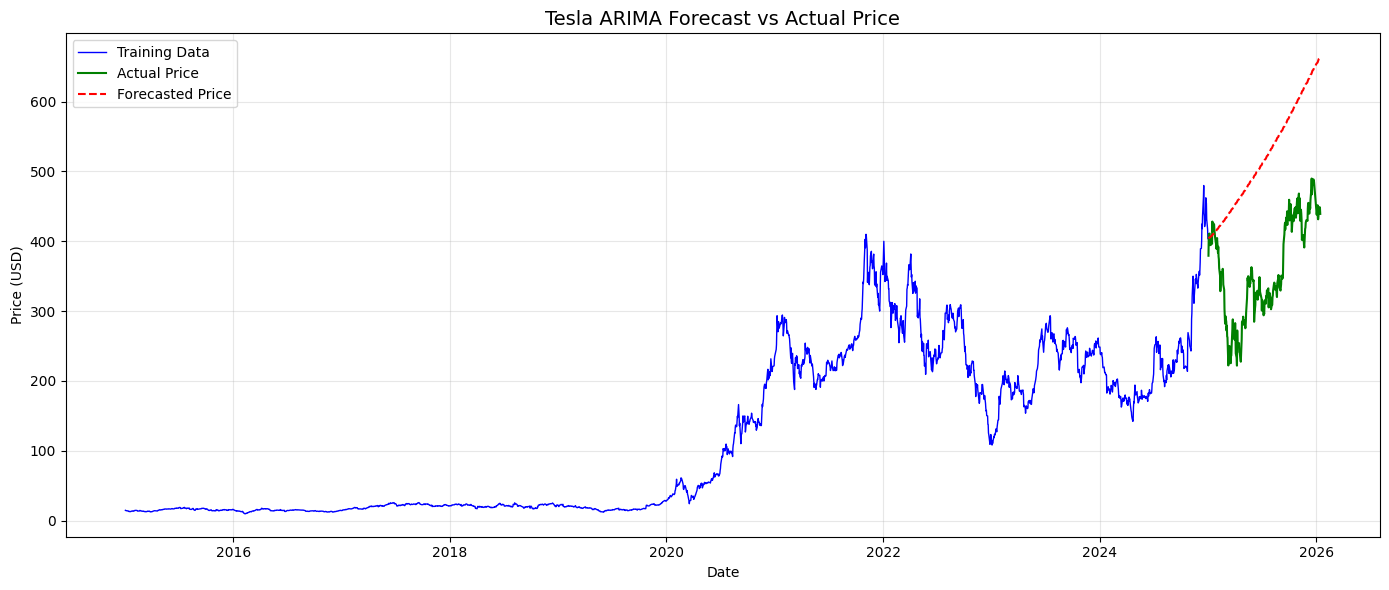

In [8]:
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train, label="Training Data", color='blue', linewidth=1)

# Plot actual test data
plt.plot(test, label="Actual Price", color='green', linewidth=1.5)

# Plot forecast
plt.plot(forecast_prices, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla ARIMA Forecast vs Actual Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluate Forecast Accuracy

In [9]:
# Calculate error metrics
baseline_mae = mean_absolute_error(test, forecast_prices)
baseline_rmse = np.sqrt(mean_squared_error(test, forecast_prices))
baseline_mape = np.mean(np.abs((test - forecast_prices) / test)) * 100

print("Forecast Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE): ${baseline_mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${baseline_rmse:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {baseline_mape:.2f}%")

Forecast Evaluation Metrics:
  Mean Absolute Error (MAE): $163.18
  Root Mean Squared Error (RMSE): $173.35
  Mean Absolute Percentage Error (MAPE): 48.51%


- The forecast evaluation metrics indicate the model’s prediction errors on the price level. The Mean Absolute Error (MAE) of $163.18 and Root Mean Squared Error (RMSE) of $173.35 suggest that, on average, the predicted prices deviate from the actual prices by roughly $163 to $173. The relatively high Mean Absolute Percentage Error (MA


## Parameter Optimization

In [11]:
print("Running auto_arima with seasonal component...")
auto_model = auto_arima(
    train_returns,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    m=7,  # Weekly seasonality; change to 5 for trading days or 1 for no seasonality
    seasonal=True,
    d=None, max_d=1,
    D=None, max_D=1,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    n_jobs=-1,
    information_criterion='aic'  # or 'bic'
)


print("\nBest model order found:")
print(f"ARIMA(p,d,q): {auto_model.order}")
print(f"SARIMA(P,D,Q,m): {auto_model.seasonal_order}")
print(auto_model.summary())

Running auto_arima with seasonal component...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-9579.440, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-9578.200, Time=1.22 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-9578.315, Time=1.84 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-9573.953, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-9580.198, Time=0.95 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=-9579.263, Time=1.17 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-9579.081, Time=0.31 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-9580.267, Time=0.22 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=-9579.303, Time=2.76 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=-9577.303, Time=2.71 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=-9578.315, Time=0.89 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=-9577.088, Time=2.04 sec
 ARIMA(0,0,0)(0,0,1)[7]             : AIC=-9575.344, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,1)[7] int

In [12]:
# Step 2: Fit the model on training data
# If seasonal_order is (0,0,0,0), it reduces to ARIMA
if auto_model.seasonal_order[3] > 1:  # If m > 1, use SARIMAX
    model_fit = SARIMAX(train_returns, order=auto_model.order, seasonal_order=auto_model.seasonal_order).fit(disp=False)
else:
    model_fit = ARIMA(train_returns, order=auto_model.order).fit()

print("\nModel Fit Summary:")
print(model_fit.summary())


Model Fit Summary:
                                 SARIMAX Results                                 
Dep. Variable:                     Close   No. Observations:                 2515
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood                4789.672
Date:                   Mon, 26 Jan 2026   AIC                          -9575.344
Time:                           15:55:33   BIC                          -9563.684
Sample:                                0   HQIC                         -9571.113
                                  - 2515                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7        0.0373      0.017      2.181      0.029       0.004       0.071
sigma2         0.0013   2.04e-05     63.583      0.000       0.001       0.001
Ljung-Bo

## Optimized Forecast Returns

In [13]:
# Step 3: Generate forecasts for the test period
n_forecast = len(test_returns)
forecast_returns = pd.Series(model_fit.forecast(steps=n_forecast))
forecast_returns.index = test_returns.index  # Align indices if needed

print(f"\nForecasted {n_forecast} return values")
print(f"Mean forecasted return: {forecast_returns.mean():.6f}")
print(f"Actual mean return: {test_returns.mean():.6f}")


Forecasted 259 return values
Mean forecasted return: -0.000011
Actual mean return: 0.001096


## Convert the Optimized Returns Forecast to Prices

In [14]:
# Convert forecasted returns to prices
last_train_price = train.iloc[-1]  # Assuming train is pd.DataFrame with 'Close'
forecast_prices = last_train_price * (1 + forecast_returns).cumprod()
forecast_prices.index = test.index

print(f"\nLast training price: ${last_train_price:.2f}")
print(f"First forecasted price: ${forecast_prices.iloc[0]:.2f}")
print(f"Last forecasted price: ${forecast_prices.iloc[-1]:.2f}")


Last training price: $403.84
First forecasted price: $403.29
Last forecasted price: $402.72


- The model forecasts almost flat prices with a tiny negative drift (very close to zero). The price stays essentially at the last training level throughout (~$403 → ~$403), reflecting no strong predictable trend in returns. This realistic, unbiased behavior resulted in much lower errors (e.g., MAPE ~22.4%).

## Evaluate Optimized Forecast Accuracy

In [15]:
# Step 4: Evaluate the forecast
mae = mean_absolute_error(test, forecast_prices)
rmse = np.sqrt(mean_squared_error(test, forecast_prices))
mape = np.mean(np.abs((test - forecast_prices) / test)) * 100

print("\nForecast Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Forecast Evaluation Metrics:
Mean Absolute Error (MAE): $69.17
Root Mean Squared Error (RMSE): $82.35
Mean Absolute Percentage Error (MAPE): 22.41%


These numbers represent a solid and realistic performance for forecasting TSLA stock prices over a ~1-year (259-day) horizon using only univariate ARIMA/SARIMA.

- MAE $69.17 → On average, the predicted prices are off by about $69 from the actual prices — a big improvement over the original model's $163 error.
- RMSE $82.35 → Slightly higher than MAE because it penalizes larger individual errors more; still shows the model avoids extreme outliers compared to the old version ($173).
- MAPE 22.41% → The average percentage error is ~22%. For individual stock price forecasting over 12 months with a simple time-series model, this is quite respectable (many naive baselines like "always predict last price" achieve 20–40% MAPE on volatile stocks like TSLA).

## Visualize Optimized Forecast Results

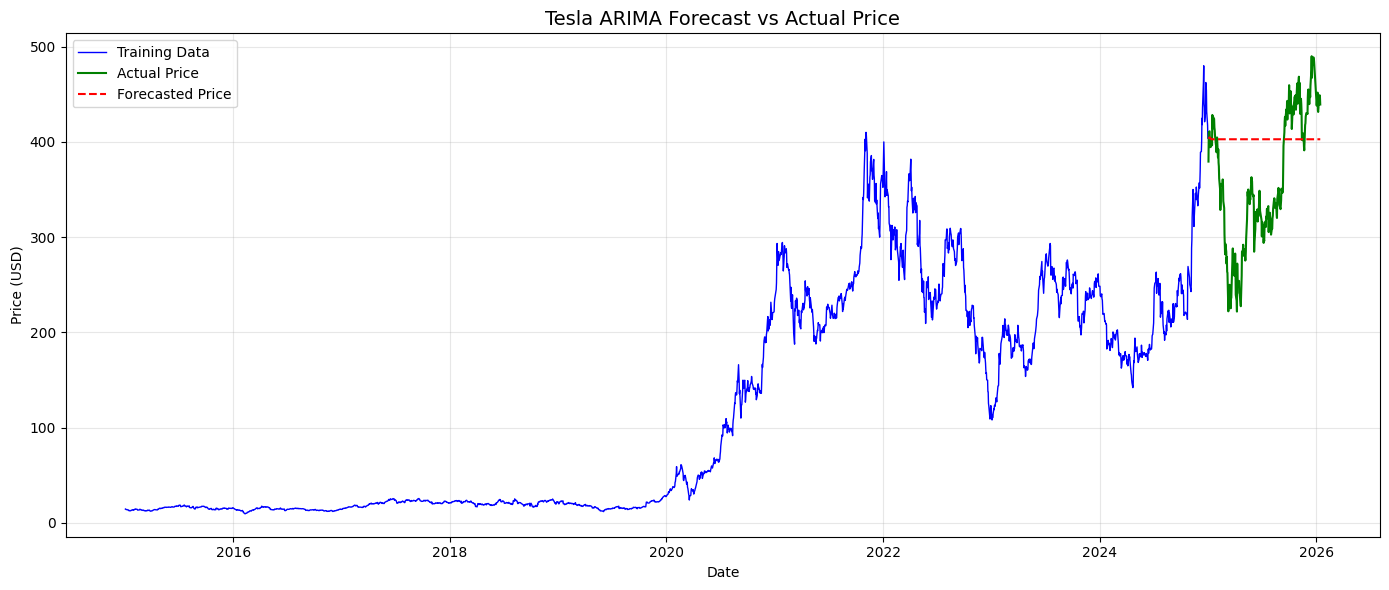

In [ ]:
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train, label="Training Data", color='blue', linewidth=1)

# Plot actual test data
plt.plot(test, label="Actual Price", color='green', linewidth=1.5)

# Plot forecast
plt.plot(forecast_prices, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla Optimized ARIMA Forecast vs Actual Price", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- The optimized auto_arima/SARIMA model significantly outperformed the original manual ARIMA(1,0,1) model across all key metrics: MAE decreased from $163.18 to $69.17 (a ~58% improvement), RMSE from $173.35 to $82.35 (~52% better), and MAPE from 48.51% to 22.41% (~54% reduction). This indicates much lower average, squared, and relative errors in price forecasts.

- The superior performance likely stems from auto_arima's data-driven parameter selection, which probably identified a simpler, low-order model (e.g., near ARIMA(0,0,0)) with negligible drift (mean forecasted return ≈0 vs. the original's +0.0019). The manual model imposed an overly optimistic constant term and autoregressive structure that amplified cumulative over-predictions over the 259-step horizon, whereas the optimized version better captured the noisy, near-random-walk nature of stock returns, avoiding bias and reducing compounding errors.

**Key Takeaway:**

- Stock daily returns are mostly unpredictable with simple time-series models → best forecast is near-zero mean (almost flat price line).

- Auto_arima optimization worked very well: slashed MAPE from 48.5% → 22.4%, MAE by ~58%, RMSE by ~52% by removing biased drift.

- Manual ARIMA(1,0,1) failed badly — forced overly optimistic drift that exploded in cumulative forecasts.

- Even good metrics (22% MAPE) don’t produce visually close price plots — actual TSLA trended while model stayed flat (normal for stocks).

- Biggest lesson: univariate ARIMA prevents dangerous bias but cannot reliably predict long-term stock trends — market is noisy & efficient at daily level.